In [ ]:
# This is included for documentation purpose, not a part of this tutorial
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

# Coupled Spring Mass System

> This Question and answer is refered from the ME211 learning materials of Faculty of Engineering, University of Peradeniya.

Consider the coupled spring mass system:

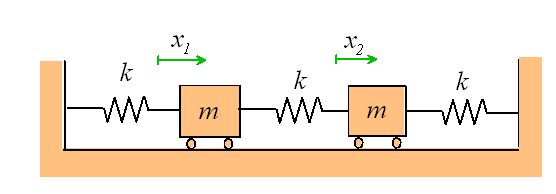

## Solve ODE

Isolating each of the masses and applying Newton's eaquations for each of them seperately we have:

$\begin{align}
m\ddot{x}_1&=-kx_1-k(x_1-x_2),\\
m\ddot{x}_2&=-kx_2-k(x_2-x_1)
\end{align}$

Which can be written as:
$\begin{align}
M\ddot{X}+KX&=0
\end{align}$
where
$\begin{align}
X=\begin{bmatrix}x_1\\x_2\end{bmatrix},\:\:\:\:
M=\begin{bmatrix}m & 0\\0 & m\end{bmatrix},\:\:\:\:
K=\begin{bmatrix}2k & -k\\ -k & 2k\end{bmatrix}
\end{align}$

This can also be written in the dynamic system form
$\begin{align}
\dot{Y}&=AY
\end{align}$
where
$\begin{align}
Y=\begin{bmatrix}x_1\\x_2\\\dot{x}_1\\\dot{x}_2\end{bmatrix},\:\:\:\:
A=\begin{bmatrix}0 & 0 & 1 &0\\ 0 & 0& 0 &1\\\frac{k}{m} & -\frac{2k}{m} & 0 &0 \\-\frac{2k}{m} & \frac{k}{m} & 0 &0
\end{bmatrix}.
\end{align}$

### Import Modules

In [ ]:
import numpy as np
from scipy.integrate import odeint
import plotly.graph_objects as go

<div class="alert alert-info">

Note

The functions `create_line_trace`, `create_point_trace`, `create_arrow_trace`, and and others were written in previous tutorials. Please include them in your notebook on top before starting to follow this tutorial. You can download it by clicking the Download icon on the Navigation Bar.

</div>

In [ ]:
def create_line_trace(start, end, color='blue', width=2, name='', dash='solid', showlegend=False):
    line_trace = go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width, dash=dash),
        name=name,
        showlegend=showlegend
    )
    return line_trace

def create_point_trace(point, color='red', size=5, name=''):
    x, y, z = point
    trace = go.Scatter3d(
        x=[x], y=[y], z=[z],
        mode='markers+text',
        marker=dict(color=color, size=size),
        text=[name],
        textposition="top center",
        showlegend=False
    )
    return trace

def create_arrow_trace(start, end, color='blue', name='', showlegend=False):
    # Create arrow shaft trace
    shaft_trace = go.Scatter3d(
        x=[start[0], end[0]], y=[start[1], end[1]], z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=5),
        name=name,
        showlegend=showlegend
    )

    # Create arrowhead trace
    vec = np.array(end) - np.array(start)
    length = np.linalg.norm(vec)
    vec_normalized = vec / length if length > 0 else vec
    arrowhead_size = 0.1 * length

    head_trace = go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[vec_normalized[0]], v=[vec_normalized[1]], w=[vec_normalized[2]],
        sizemode="absolute", sizeref=arrowhead_size, showscale=False,
        anchor="tip", colorscale=[[0, color], [1, color]]
    )

    return [shaft_trace, head_trace]

def create_3d_layout(title='3D Plot', gridcolor='lightblue', xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis'):
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=xaxis_title),
            yaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=yaxis_title),
            zaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=zaxis_title),
        ),
        scene_aspectmode='cube'
    )
    return layout

def create_orthonormal_frame_traces(frame_name='e', origin=[0, 0, 0], length=1, color='blue', rotation_matrix=np.identity(3)):
    # Define standard basis vectors
    i = np.array([1, 0, 0])
    j = np.array([0, 1, 0])
    k = np.array([0, 0, 1])

    # Apply rotation
    i_rot = np.dot(rotation_matrix, i)
    j_rot = np.dot(rotation_matrix, j)
    k_rot = np.dot(rotation_matrix, k)

    # Create traces for rotated axes with arrows
    frame_traces = []
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * i_rot, color=color, name=f'{frame_name}_x'))
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * j_rot, color=color, name=f'{frame_name}_y'))
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * k_rot, color=color, name=f'{frame_name}_z'))

    return frame_traces

def animate_particle(curve_points, particle_name='Particle', particle_color='red', particle_size=6, animation_speed=10):
    # Creating frames for animation
    frames = []
    for i in range(0, len(curve_points), animation_speed):
        frame = go.Frame(data=[go.Scatter3d(
            x=[curve_points[i][0]],
            y=[curve_points[i][1]],
            z=[curve_points[i][2]],
            mode='markers+text',
            marker=dict(color=particle_color, size=particle_size),
            text=[particle_name],
            textposition='top center',
            textfont=dict(size=15)
        )])
        frames.append(frame)

    return frames

def create_particle_animation(curve_points, title='Particle Animation', name='P', origin=[0, 0, 0]):

    # Validate curve_points
    if not isinstance(curve_points, np.ndarray):
        raise ValueError("curve_points must be a NumPy array.")
    if curve_points.size == 0 or curve_points.ndim != 2 or curve_points.shape[1] != 3:
        raise ValueError("curve_points must be a non-empty 2D NumPy array with 3 columns (x, y, z coordinates).")

    traces = []
    frames = []

    x_vals, y_vals, z_vals = zip(*curve_points)

    # Add initial point and origin 'O'
    traces.append(create_point_trace(curve_points[0], color='green', size=8, name=name))
    traces.append(create_point_trace(origin, color='black', size=3, name='O'))

    # Set layout for the figure
    layout = create_3d_layout(title=title, xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis')

    # Add path trace
    traces.append(go.Scatter3d(
        x=x_vals, y=y_vals, z=z_vals,
        mode="lines",
        line=dict(color="blue", width=2),
        name='Path'
    ))

    # Animate the particle
    frames = animate_particle(curve_points, name, particle_color='green', particle_size=8, animation_speed=1)

    fig = go.Figure(data=traces, layout=layout, frames=frames)

    # Adjust the camera settings
    fig.update_layout(
        scene=dict(
            camera=dict(
                up=dict(x=0, y=0, z=1),  # Sets the up direction (in this case, the z-axis is up)
                center=dict(x=0, y=0, z=0),  # Centers the view on the given coordinates
                eye=dict(x=1, y=-1.25, z=1.25)  # Sets the position of the camera
            ),
            aspectmode='cube'  # Keeps the aspect ratio of the axes fixed
        )
    )

    # Add play and pause buttons
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(label="Play",
                          method="animate",
                          args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)]),
                    dict(label="Pause",
                          method="animate",
                          args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")])
                ]
            )
        ]
    )

    return fig

### Define System Function

In [ ]:
def system_dynamics(Y, t, k, m):
    A = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [-2*k/m, k/m, 0, 0],
                  [k/m, -2*k/m, 0, 0]])
    dYdt = A@Y
    return dYdt

### Constants and Conditions

In [ ]:
# parameters and initial conditions
k = 1.0  # Spring constant
m = 1.0  # Mass
x1_0, x2_0 = 0.5, -0.5  # Initial positions
v1_0, v2_0 = 0.1, 0.1   # Initial velocities
Y0 = [x1_0, x2_0, v1_0, v2_0]
t = np.linspace(0, 10, 250)  # Time points


### Solve ODE

In [ ]:
# Solve ODE
solution = odeint(system_dynamics, Y0, t, args=(k, m))

# Extract positions and velocities
x1_vals, x2_vals = solution[:, 0], solution[:, 1]
v1_vals, v2_vals = solution[:, 2], solution[:, 3]

### Plot the Solutions

In [ ]:
# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=x1_vals, mode='lines', name='x1 (Position)'))
fig.add_trace(go.Scatter(x=t, y=x2_vals, mode='lines', name='x2 (Position)'))
fig.add_trace(go.Scatter(x=t, y=v1_vals, mode='lines', name='v1 (Velocity)', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=t, y=v2_vals, mode='lines', name='v2 (Velocity)', line=dict(dash='dash')))

fig.update_layout(title='Mass-Spring System Dynamics',
                  xaxis_title='Time (s)',
                  yaxis_title='Position / Velocity',
                  legend_title='Variable')

fig.show()


### Animation

In [ ]:
fig = go.Figure(
    data=[go.Scatter(x=[x1_vals[0]+0.5, x2_vals[0]-0.5], y=[0, 0], mode='markers', marker=dict(size=20, color=['red', 'blue']), name='Masses')],
    layout=go.Layout(
        xaxis=dict(range=[-1, 1], autorange=False),
        yaxis=dict(range=[-1, 1], autorange=False, scaleanchor="x", scaleratio=1),
        title="Animation of Two-Mass, Two-Spring System",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 50, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause",
                         method="animate",
                         args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])])]
    ),
    frames=[go.Frame(data=[go.Scatter(x=[x1_vals[k]+0.5, x2_vals[k]-0.5], y=[0, 0], mode='markers', marker=dict(size=20, color=['red', 'blue']))])
            for k in range(len(t))]
)

fig.show()

### Energy

In [ ]:
# Calculating energies
KE = 0.5 * m * (solution[:, 2]**2 + solution[:, 3]**2)  # Kinetic Energy: 0.5 * m * v^2
PE = 0.5 * k * (solution[:, 0]**2 + solution[:,1]**2 +(solution[:, 0] - solution[:, 1])**2)  # Potential Energy: 0.5 * k * x^2
TE = KE + PE  # Total Energy

# Plotting energies
energy_fig = go.Figure()
energy_fig.add_trace(go.Scatter(x=t, y=KE, mode='lines', name='Kinetic Energy'))
energy_fig.add_trace(go.Scatter(x=t, y=PE, mode='lines', name='Potential Energy'))
energy_fig.add_trace(go.Scatter(x=t, y=TE, mode='lines', name='Total Energy'))

energy_fig.update_layout(title='Energy of the Mass-Spring System',
                         xaxis_title='Time (s)',
                         yaxis_title='Energy',
                         legend_title='Type of Energy')

energy_fig.show()


### Linear Momentum

In [ ]:
P=m*solution[:,2]+m*solution[:,3]
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=P, mode='lines',name='Linear Momentum'))
fig.update_layout(title='Linear Momentum Vs Time')
fig.show()